## Optimizer

In [52]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

### スクラッチ実装

In [53]:
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_output):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x

In [54]:
# モデルの定義
model = MLP(64, 30, 10)

In [55]:
# パラメータの更新の役割を持つクラス
class Optimizer():

    def __init__(self, parameters, lr=0.03):
        self.parameters = list(parameters)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

In [56]:
learning_rate = 0.01
opt = Optimizer(parameters=model.parameters(), lr=learning_rate)

In [57]:
# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

# 学習データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# 2. 前処理
# 2-1. ラベルのonehotencoding
y_train = torch.tensor(y_train)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)
y_val = torch.tensor(y_val)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()

batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)
epochs = 100

# ログ
train_losses = []
val_losses = []
val_accuracies = []

# 5. for文で学習ループ作成
for epoch in range(epochs):

    shuffled_indcies = np.random.permutation(len(y_train))   # データのindexをシャッフル
    running_loss = 0.0

    for i in range(num_batches):

        # mini-batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indcies[start:end]

        # 6. 入力データxおよび教師ラベルのYを作成
        y = y_train[batch_indices]
        X = X_train[batch_indices]


        # 順伝播と逆伝播の計算
        preds = model(X)
        loss = F.cross_entropy(preds, y)
        loss.backward()
        running_loss += loss.item()

        # パラメータ更新
        opt.step()
        opt.zero_grad()

    # validation
    with torch.no_grad():
        preds_val = model(X_val)
        val_loss = F.cross_entropy(preds_val, y_val)
        val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    
    # 損失ログ出力
    print(f'epoch: {epoch+1}: train_loss:{running_loss/num_batches}, val_loss:{val_loss.item()}, val_acuraccy:{val_accuracy.item()}')

epoch: 1: train_loss:2.2347779323657355, val_loss:2.22503399848938, val_acuraccy:0.22499999403953552
epoch: 2: train_loss:2.103434686859449, val_loss:1.8438259363174438, val_acuraccy:0.3777777850627899
epoch: 3: train_loss:1.967578925192356, val_loss:1.5903135538101196, val_acuraccy:0.4555555582046509
epoch: 4: train_loss:1.8145780935883522, val_loss:1.39430570602417, val_acuraccy:0.4972222149372101
epoch: 5: train_loss:1.6487580637137096, val_loss:1.2362138032913208, val_acuraccy:0.5861111283302307
epoch: 6: train_loss:1.4774291614691417, val_loss:0.9910792708396912, val_acuraccy:0.6805555820465088
epoch: 7: train_loss:1.3062393541137378, val_loss:0.8107516169548035, val_acuraccy:0.7388888597488403
epoch: 8: train_loss:1.143602129071951, val_loss:0.6853277683258057, val_acuraccy:0.7861111164093018
epoch: 9: train_loss:0.9960281066596508, val_loss:0.5724626779556274, val_acuraccy:0.8500000238418579
epoch: 10: train_loss:0.8687781703968843, val_loss:0.5415550470352173, val_acuraccy:0.86

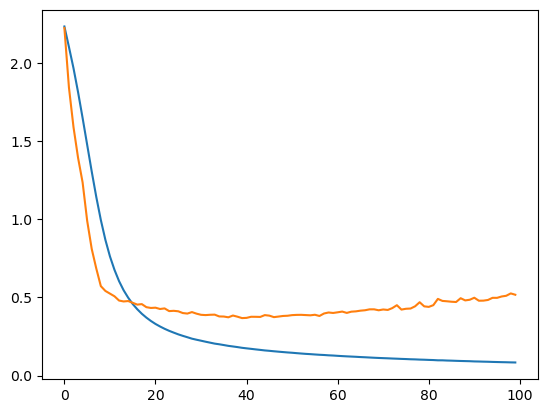

In [58]:
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')

### torch.optim

In [59]:
from torch import optim
opt = optim.SGD(model.parameters(), lr=0.01)

In [60]:
# ログ
train_losses = []
val_losses = []
val_accuracies = []

# 5. for文で学習ループ作成
for epoch in range(epochs):

    shuffled_indcies = np.random.permutation(len(y_train))   # データのindexをシャッフル
    running_loss = 0.0

    for i in range(num_batches):

        # mini-batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indcies[start:end]

        # 6. 入力データxおよび教師ラベルのYを作成
        y = y_train[batch_indices]
        X = X_train[batch_indices]


        # 順伝播と逆伝播の計算
        preds = model(X)
        loss = F.cross_entropy(preds, y)
        loss.backward()
        running_loss += loss.item()

        # パラメータ更新
        opt.step()
        opt.zero_grad()

    # validation
    with torch.no_grad():
        preds_val = model(X_val)
        val_loss = F.cross_entropy(preds_val, y_val)
        val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    
    # 損失ログ出力
    print(f'epoch: {epoch+1}: train_loss:{running_loss/num_batches}, val_loss:{val_loss.item()}, val_acuraccy:{val_accuracy.item()}')

epoch: 1: train_loss:0.08258983651952197, val_loss:0.5078864097595215, val_acuraccy:0.9333333373069763
epoch: 2: train_loss:0.08179402630776167, val_loss:0.5268282294273376, val_acuraccy:0.9305555820465088
epoch: 3: train_loss:0.08088312072989841, val_loss:0.5232627391815186, val_acuraccy:0.9333333373069763
epoch: 4: train_loss:0.08042843356573333, val_loss:0.5264818072319031, val_acuraccy:0.9305555820465088
epoch: 5: train_loss:0.07992078476430227, val_loss:0.5297555923461914, val_acuraccy:0.9305555820465088
epoch: 6: train_loss:0.0791451148300742, val_loss:0.5192336440086365, val_acuraccy:0.9333333373069763
epoch: 7: train_loss:0.07847737330788125, val_loss:0.5321016311645508, val_acuraccy:0.9305555820465088
epoch: 8: train_loss:0.07795297699825217, val_loss:0.5385628938674927, val_acuraccy:0.9305555820465088
epoch: 9: train_loss:0.07701483233055721, val_loss:0.5517548322677612, val_acuraccy:0.9277777671813965
epoch: 10: train_loss:0.07643191341776401, val_loss:0.5468196272850037, va